<a href="https://colab.research.google.com/github/BenzThitikorn/Vector-Symbol-Decoding-with-AI/blob/main/Data_Generation_Using_PYLDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- 1. Setup Environment ---

In [ ]:
# Clone the repository (if running in Colab for the first time)
#!git clone https://github.com/BenzThitikorn/Vector-Symbol-Decoding-with-AI.git

# Navigate to the repository directory
#cd /content/Vector-Symbol-Decoding-with-AI

# Install the pyldpc library
#!pip install --upgrade pyldpc

Cloning into 'Vector-Symbol-Decoding-with-AI'...
remote: Enumerating objects: 11753, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 11753 (delta 5), reused 19 (delta 2), pack-reused 11729 (from 2)
Receiving objects: 100% (11753/11753), 52.85 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (653/653), done.


# --- 2. LDPC Code Parameters ---

In [1]:
from pyldpc import make_ldpc

d_v = 3  # Variable node degree
d_c = 6  # Check node degree

n = 30 #Code lenght
r = 16 #Symbol lenght

# Generate parity check matrix (H) and generator matrix (G)
H, Gt = make_ldpc(n, d_v=d_v, d_c=d_c, systematic=True, sparse=True, seed=1)
G = Gt.T  # Transpose of Gt to get G
j = G.shape[0]  # Number of rows in G

print(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")
print(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")

H matrix: 15 rows, 30 columns
G matrix: 17 rows, 30 columns


# --- 3. Import Libraries and Custom Modules ---

In [ ]:
#cd Function/

[Errno 2] No such file or directory: 'Function/'
/Users/benzomorphism/Documents/Research(To be arrange)/Vector-Symbol-Decoding-with-AI/Function


In [13]:
import Channel_Coding as cc
import numpy as np
from CCv2 import Compute_Gauss_Jordan_Reduction_Optimized, VSD_normal_get0fast

def q_ary_error_channel(prob_error,num):
	rng = np.random.default_rng()
	Probability = [1-prob_error, prob_error]
	channel = rng.choice(2, num, p=Probability)
	return channel

def VSD_normal(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = Compute_Gauss_Jordan_Reduction_Optimized(S_Binary)

    # Compute Error Locating Vector
    Error_Locating_Vector = cc.Compute_Error_Locating_Vector(S_Gauss, Index_Rows, H)

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("normal",H_Sub)
            return Y_Binary, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        return Y_decode, 1  # Successful correction
    else:
        return Y_Binary, 0  # Unable to correct errors

# --- 4. Simulation (Single Sample) ---

In [15]:
from scipy.sparse import random as sparse_random

num_samples = 1
SER = 0.1  # Symbol Error Rate

for i in range(num_samples):
    error_positions = q_ary_error_channel(SER, n)  # Generate error positions
    message = np.random.randint(0, 2, (r, j))  # Generate a random message
    codeword = np.matmul(message, G).astype(np.int8) % 2  # Encode the message
    error = np.zeros_like(codeword)  # Initialize error vector
    error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions), density=0.5, format='csr', dtype=int).toarray() % 2  # Introduce errors
    Y = (codeword + error) % 2  # Received codeword
    Y_decode, success = VSD_normal(H, Y.T)  # Decode the received codeword

    if success == 1:
        print("Decoding successful")
    else:
        print("Decoding failed")

# Verify decoding result
if 'Y_decode' in locals() and np.array_equal(Y_decode.T, codeword):
    print("All decoded values match codeword")
else:
    print("Decoded values don't match codeword")

Decoding successful
All decoded values match codeword


# --- 5. Data Generation Function ---

In [ ]:
from tqdm import tqdm
import pickle  # For saving data

def generate_data(num_samples, SER, H, G):
    """
    Generate training data for the LDPC code decoder with tqdm progress.
    Stores X and Y if the process is interrupted.

    Parameters:
    - num_samples: Number of samples to generate
    - SER: Symbol Error Rate
    - H: Parity check matrix
    - G: Generator matrix

    Returns:
    - X: Array of syndromes (features)
    - Y: Array of error positions (labels)
    """
    X = []
    Y = []

    try:
        for i in tqdm(range(num_samples), desc="Generating Data"):
            error_positions = q_ary_error_channel(SER, n)
            message = np.random.randint(0, 2, (r, j))
            codeword = np.matmul(message, G).astype(np.int8) % 2
            error = np.zeros_like(codeword)
            error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions), density=0.5, format='csr', dtype=int).toarray() % 2
            received = (codeword + error) % 2
            syndrome = np.dot(H, received.T) % 2
            Y_decode, success = VSD_normal_get0fast(H, received.T)

            if success == 0:
                X.append(syndrome)
                Y.append((error_positions + 1) % 2)

    except KeyboardInterrupt:
        print("\nGeneration interrupted. Saving progress...")
        with open("interrupted_data.pkl", "wb") as f:
            pickle.dump({"X": X, "Y": Y}, f)
        print("Progress saved to interrupted_data.pkl")
        return np.array(X).astype(bool), np.array(Y).astype(bool) #return the data that was generated.

    print(f"\nGenerated {len(X)} samples from {num_samples} iterations")
    return np.array(X).astype(bool), np.array(Y).astype(bool)

# --- 6. Generate and Save Data ---


In [ ]:
# Generate data
X, Y = generate_data(num_samples=1000, SER=0.1, H=H, G=G)
# Save the generated data
np.save('X_data.npy', X)
np.save('Y_data.npy', Y)

Generating Data: 100%|██████████| 1000/1000 [00:00<00:00, 1445.48it/s]


Generated 231 samples from 1000 iterations


# --- 7. Function to Extract Unique Samples ---

In [ ]:
def get_unique_x_and_y(X, Y):
    """
    Filters X and Y to keep only unique X values and their corresponding Y values.

    Args:
        X: NumPy array of shape (num_samples, 15, 16).
        Y: NumPy array of shape (num_samples, ...). Y can have any shape, but the first dimension must match X.

    Returns:
        unique_X: NumPy array containing only unique X values.
        unique_Y: NumPy array containing the corresponding Y values.
    """

    if X.shape[0] != Y.shape[0]:
        raise ValueError("X and Y must have the same number of samples (first dimension).")

    unique_indices = []
    seen_X = set()

    for i in range(X.shape[0]):
        x_tuple = tuple(X[i].flatten())  # Flatten X[i] for hashing

        if x_tuple not in seen_X:
            seen_X.add(x_tuple)
            unique_indices.append(i)

    unique_X = X[unique_indices]
    unique_Y = Y[unique_indices]

    return unique_X, unique_Y

## --- Extract Unique Data and Save ---

In [ ]:
unique_X, unique_Y = get_unique_x_and_y(X, Y)

np.save('unique_X.npy', unique_X)
np.save('unique_Y.npy', unique_Y)

In [36]:
unique_X.shape

(1701943, 15, 16)

# Appendix

## --- Gauss-Jordan Elimination Comparison ---

In [25]:
from numpy.random import randint
import time
import matplotlib.pyplot as plt

def Compute_Gauss_Jordan_Reduction_Optimized(Original_matrix):
    """
    Optimized Gauss-Jordan elimination implementation.

    Args:
        Original_matrix: The input matrix.

    Returns:
        The reduced matrix, rank, and row indices.
    """
    Binary_matrix = np.array(Original_matrix, dtype=int)
    index_operation_col = 0
    rows = 0
    Index_Rows = []
    num_rows, num_cols = Binary_matrix.shape

    while rows < num_rows and index_operation_col < num_cols:
        columns_one = np.where(Binary_matrix[rows, :] == 1)[0]
        if len(columns_one) > 0:
            if index_operation_col in columns_one:
                other_indices = columns_one[columns_one != index_operation_col]
                if len(other_indices) > 0:
                    Binary_matrix[:, other_indices] ^= Binary_matrix[:, [index_operation_col]]
                Index_Rows.append(rows)
                index_operation_col += 1
                rows += 1
            else:
                change_index_col = columns_one[columns_one > index_operation_col]
                if len(change_index_col) > 0:
                    Binary_matrix[:, [index_operation_col, change_index_col[0]]] = Binary_matrix[:, [change_index_col[0], index_operation_col]]
                else:
                    rows += 1
        else:
            rows += 1
    return Binary_matrix, index_operation_col, Index_Rows

In [26]:
# Example matrix for testing
A = randint(0, 2, (50, 50))

# Time the original and optimized Gauss-Jordan implementations
start_time = time.time()
result1, rank1, rows1 = cc.Compute_Gauss_Jordan_Reduction(A)
time1 = time.time() - start_time

start_time = time.time()
result2, rank2, rows2 = Compute_Gauss_Jordan_Reduction_Optimized(A)
time2 = time.time() - start_time

# Check if results are equal
matrices_equal = np.array_equal(result1, result2)
ranks_equal = rank1 == rank2
rows_equal = rows1 == rows2

print(f"Matrices equal: {matrices_equal}")
print(f"Ranks equal: {ranks_equal}")
print(f"Row indices equal: {rows_equal}")
print(f"Time for original method: {time1:.6f} seconds")
print(f"Time for optimized method: {time2:.6f} seconds")
print(f"Speedup: {time1/time2:.2f}x")

# Overall equality
all_equal = matrices_equal and ranks_equal and rows_equal
print(f"All results equal: {all_equal}")


Matrices equal: True
Ranks equal: True
Row indices equal: True
Time for original method: 0.070056 seconds
Time for optimized method: 0.002136 seconds
Speedup: 32.80x
All results equal: True


# --- Function to Compare Gauss-Jordan Implementations ---


In [ ]:
def compare_gauss_jordan_implementations(matrix_sizes=[50, 100, 200, 300, 400, 500], trials=5):
    """
    Compares the performance of the original and optimized Gauss-Jordan implementations.

    Args:
        matrix_sizes: List of matrix sizes to test.
        trials: Number of trials to run for each matrix size.

    Returns:
        A dictionary containing the results of the comparison.
    """
    times_original = []
    times_optimized = []

    for size in tqdm(matrix_sizes, desc="Testing different matrix sizes"):
        time_orig = 0
        time_opt = 0

        for _ in range(trials):
            # Generate random binary matrix
            test_matrix = np.random.randint(0, 2, (size, size))

            # Time original implementation
            start = time.time()
            gauss_orig, rank_orig, rows_orig = cc.Compute_Gauss_Jordan_Reduction(test_matrix)
            time_orig += time.time() - start

            # Time optimized implementation
            start = time.time()
            gauss_opt, rank_opt, rows_opt = Compute_Gauss_Jordan_Reduction_Optimized(test_matrix)
            time_opt += time.time() - start

            # Verify results match
            if not np.array_equal(gauss_orig, gauss_opt) or rank_orig != rank_opt:
                print(f"Warning: Results don't match for matrix size {size}")

        times_original.append(time_orig / trials)
        times_optimized.append(time_opt / trials)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(matrix_sizes, times_original, 'o-', label='Original Implementation')
    plt.plot(matrix_sizes, times_optimized, 's-', label='Optimized Implementation')
    plt.xlabel('Matrix Size')
    plt.ylabel('Average Time (seconds)')
    plt.title('Performance Comparison of Gauss-Jordan Reduction Implementations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate speedup
    speedup = [t1/t2 for t1, t2 in zip(times_original, times_optimized)]
    plt.figure(figsize=(10, 6))
    plt.plot(matrix_sizes, speedup, 'o-')
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup Factor')
    plt.title('Speedup from Optimization')
    plt.grid(True)
    plt.show()

    # Print summary
    print("\nPerformance Summary:")
    print("Matrix Size | Original (s) | Optimized (s) | Speedup")
    print("-" * 55)
    for i, size in enumerate(matrix_sizes):
        print(f"{size:11d} | {times_original[i]:12.6f} | {times_optimized[i]:12.6f} | {speedup[i]:7.2f}x")

    return {
        'matrix_sizes': matrix_sizes,
        'times_original': times_original,
        'times_optimized': times_optimized,
        'speedup': speedup
    }


## ---  Run the Comparison ---

Testing different matrix sizes: 100%|██████████| 8/8 [32:52<00:00, 246.59s/it]


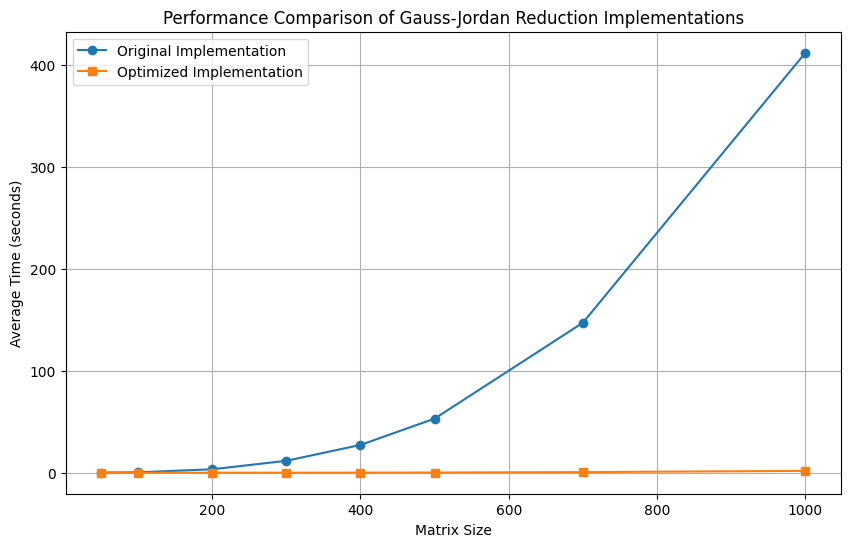

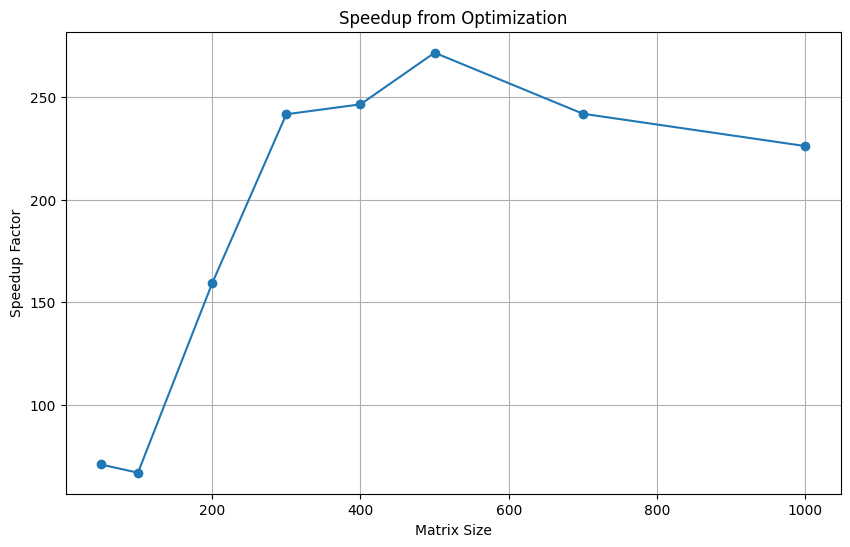


Performance Summary:
Matrix Size | Original (s) | Optimized (s) | Speedup
-------------------------------------------------------
         50 |     0.124855 |     0.001764 |   70.78x
        100 |     0.413609 |     0.006195 |   66.77x
        200 |     3.378847 |     0.021236 |  159.11x
        300 |    11.685164 |     0.048363 |  241.61x
        400 |    27.241792 |     0.110539 |  246.45x
        500 |    53.041288 |     0.195275 |  271.62x
        700 |   147.088089 |     0.608154 |  241.86x
       1000 |   411.760151 |     1.821325 |  226.08x


{'matrix_sizes': [50, 100, 200, 300, 400, 500, 700, 1000],
 'times_original': [0.12485464413960774,
  0.41360926628112793,
  3.378847042719523,
  11.685164054234823,
  27.241791884104412,
  53.04128829638163,
  147.08808914820352,
  411.7601507504781],
 'times_optimized': [0.0017639795939127605,
  0.006194591522216797,
  0.021236260732014973,
  0.04836320877075195,
  0.11053856213887532,
  0.19527546564737955,
  0.6081539789835612,
  1.8213249842325847],
 'speedup': [70.78009551270499,
  66.76941728889231,
  159.10743823302673,
  241.6126711034426,
  246.44604884473836,
  271.6229000941748,
  241.8599470384776,
  226.07725382077996]}

In [32]:
compare_gauss_jordan_implementations(matrix_sizes=[50, 100, 200, 300, 400, 500, 700, 1000], trials=3)

In [39]:
import numpy as np
from tqdm import tqdm

# Simulate random matrices and count how many times the results are equal

num_simulations = 1000
equal_count = 0
rank_equal_count = 0
rows_equal_count = 0

for i in tqdm(range(num_simulations), desc="Running simulations"):
    # Generate random binary matrix of appropriate size
    test_matrix = np.random.randint(0, 2, (30, 30))
    
    # Run both implementations
    result1, rank1, rows1 = cc.Compute_Gauss_Jordan_Reduction(test_matrix)
    result2, rank2, rows2 = Compute_Gauss_Jordan_Reduction_Optimized(test_matrix)
    
    # Check if results are equal
    if np.array_equal(result1, result2):
        equal_count += 1
    
    if rank1 == rank2:
        rank_equal_count += 1
        
    if rows1 == rows2:
        rows_equal_count += 1

# Print results
print(f"Matrix equality: {equal_count}/{num_simulations} ({equal_count/num_simulations*100:.2f}%)")
print(f"Rank equality: {rank_equal_count}/{num_simulations} ({rank_equal_count/num_simulations*100:.2f}%)")
print(f"Row indices equality: {rows_equal_count}/{num_simulations} ({rows_equal_count/num_simulations*100:.2f}%)")
print(f"Perfect equality: {(equal_count == rank_equal_count == rows_equal_count == num_simulations)}")



Running simulations: 100%|██████████| 1000/1000 [00:07<00:00, 125.20it/s]

Matrix equality: 1000/1000 (100.00%)
Rank equality: 1000/1000 (100.00%)
Row indices equality: 1000/1000 (100.00%)
Perfect equality: True
